In [1]:
import numpy as np
import util
from prev_problems_modules import p01b_logreg
WILDCARD = 'X'


def part_c(train_path, valid_path, test_path, pred_path):
    """Problem 2: Logistic regression for incomplete, positive-only labels.

    Run under the following conditions:
        1. on y-labels,
        2. on l-labels,
        3. on l-labels with correction factor alpha.

    Args:
        train_path: Path to CSV file containing training set.
        valid_path: Path to CSV file containing validation set.
        test_path: Path to CSV file containing test set.
        pred_path: Path to save predictions.
    """
    pred_path_c = pred_path.replace(WILDCARD, 'c')
    pred_path_d = pred_path.replace(WILDCARD, 'd')
    pred_path_e = pred_path.replace(WILDCARD, 'e')

    # Part (c): Train and test on true labels
    # use true labels, and x1, x2, making sure to use t labels
    x_train_c, y_train_c = util.load_dataset(train_path, label_col='t', add_intercept=True)
    model_with_true_labels = p01b_logreg.LogisticRegression()
    model_with_true_labels.fit(x_train_c, y_train_c)
    # Make sure to save outputs to pred_path_c
    # plot the predictions 
    # output trained model's predictions on the test set 
    x_test_c, y_test_c = util.load_dataset(test_path, label_col='t', add_intercept=True)
    pred_labels_c = model_with_true_labels.predict(x_test_c)
    # plot it 
    np.savetxt(pred_path + 'p02d_predicts.txt',model_with_true_labels.predict(x_test_c))
    util.plot(x_test_c, y_test_c, model_with_true_labels.theta.T, text="Part C", save_path=pred_path + 'p02cTest.png')

def part_d(train_path, valid_path, test_path, pred_path):
    # Part (d): Train on y-labels and test on true labels
    # retrain the classifier, but with y instead of t 
    x_train_d, y_train_d = util.load_dataset(train_path, label_col='y', add_intercept=True)
    model_with_y_only = p01b_logreg.LogisticRegression()
    model_with_y_only.fit(x_train_d, y_train_d)
    # run it on the test set
    x_test_d, y_test_d = util.load_dataset(test_path, label_col = 'y', add_intercept=True)
    util.plot(x_test_d, y_test_d, model_with_y_only.theta.T, text="Part D", save_path=pred_path + 'p02dTest.png')
    np.savetxt(pred_path + 'p02d_predicts.txt',model_with_y_only.predict(x_test_d))
    # Make sure to save outputs to pred_path_d

def part_e(train_path, valid_path, test_path, pred_path):
    # Part (e): Apply correction factor using validation set and test on true labels
    # apply correction factor, using the validation set, estimate the constant alpha, by averaging
    # you're classifier's prediction over all labeled datasets
    x_train_e, y_train_e = util.load_dataset(train_path, label_col='y', add_intercept=True)
    model_with_y_only = p01b_logreg.LogisticRegression()
    model_with_y_only.fit(x_train_e, y_train_e)
    x_test_e, y_test_e = util.load_dataset(test_path, label_col = 'y', add_intercept=True)
    
    x_valid_e, y_valid_e = util.load_dataset(valid_path, add_intercept=True)
    # we want to reduce the valid set to only those with y == 1 
    mask = np.where(y_valid_e == 1)
    x_valid_e_masked = x_valid_e[mask]
    # the equation is sum(h(x)) / num examples in V+
    validation_predictions = model_with_y_only.predict(x_valid_e_masked)
    print(validation_predictions)
    _, columns = validation_predictions.shape
    labeling_rate = (np.sum(validation_predictions)) / columns
    print("Labeling rate alpha ", labeling_rate)
    # take correction to plotting 
    print(f"With Correction of {labeling_rate}")
    #util.plot(x_train_e, y_train_e, model_with_y_only.theta.T, correction=labeling_rate, save_path='p02eTrain.png')
    #util.plot(x_test_e, y_test_e, model_with_y_only.theta.T, correction=labeling_rate, save_path='p02eTest.png')
    # Plot and use np.savetxt to save outputs to pred_path_e
    # create a new class 
    class ScaledWithAlphaLogReg(p01b_logreg.LogisticRegression):
        def __init__(self, labeling_rate, step_size=0.2, max_iter=100, eps=1e-5, theta_0=None, verbose=True):
            super().__init__(step_size=step_size, max_iter=max_iter, eps = eps, theta_0=theta_0, verbose=verbose)
            self.labeling_rate = labeling_rate  
        def predict(self, x):
            return (self.sigmoid(np.dot(self.theta, x.T))) / self.labeling_rate

    scaled_model = ScaledWithAlphaLogReg(labeling_rate)
    scaled_model.fit(x_train_e, y_train_e)
    np.savetxt(pred_path + 'p02e_predicts.txt',model_with_y_only.predict(x_test_e))

    ### Changed plot function to see our predictions 
    def plot(x, y, predict, save_path=None, text=""):
        """Plot dataset and fitted logistic regression decision boundary using a predict function.
        Args:
            x: Matrix of training examples, one per row.
            y: Vector of labels in {0, 1}.
            predict: Function to predict outputs given inputs.
            save_path: Path to save the plot.
            correction: Correction factor to apply (Problem 2(e) only).
        """
        import numpy as np
        import matplotlib.pyplot as plt
        
        # Plot dataset
        plt.figure()
        plt.plot(x[y == 1, -2], x[y == 1, -1], 'bx', linewidth=2, label='Class 1')
        plt.plot(x[y == 0, -2], x[y == 0, -1], 'go', linewidth=2, label='Class 0')

        # Plot decision boundary
        margin1 = (max(x[:, -2]) - min(x[:, -2])) * 0.2
        margin2 = (max(x[:, -1]) - min(x[:, -1])) * 0.2
        x1_vals = np.linspace(min(x[:, -2]) - margin1, max(x[:, -2]) + margin1, 500)
        x2_vals = np.linspace(min(x[:, -1]) - margin2, max(x[:, -1]) + margin2, 500)
        x1, x2 = np.meshgrid(x1_vals, x2_vals)

        grid_points = np.c_[np.ones(x1.ravel().shape[0]), x1.ravel(), x2.ravel()]  # Adding bias term
        predictions = predict(grid_points) > 0.5  # Assuming the predict function outputs probabilities

        # Reshape predictions to match the grid shape
        predictions = predictions.reshape(x1.shape)

        # Plot the decision boundary
        plt.contour(x1, x2, predictions, levels=[0.5], colors='red', linewidths=2)
        plt.xlim(x[:, -2].min() - margin1, x[:, -2].max() + margin1)
        plt.ylim(x[:, -1].min() - margin2, x[:, -1].max() + margin2)

        # Add labels, legend, and save the plot
        plt.xlabel('x1')
        plt.ylabel('x2')
        if text:
            plt.title(text)
        plt.legend()
        if save_path is not None:
            plt.savefig(save_path)
        plt.show()
    plot(x_test_e, y_test_e, scaled_model.predict, text="Part E")
    # *** END CODER HERE


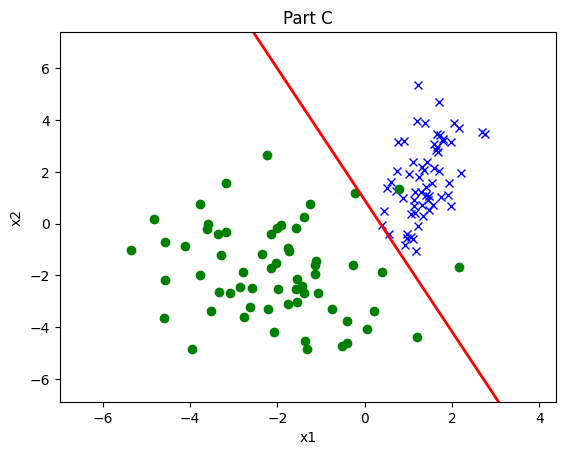

In [2]:
# use dataset 3 

ds3_train = '../data/ds3_train.csv'
ds3_valid = '../data/ds3_valid.csv'
ds3_test = '../data/ds3_test.csv'
save_path = '../save_runs/'

part_c(ds3_train, ds3_valid, ds3_test, save_path)


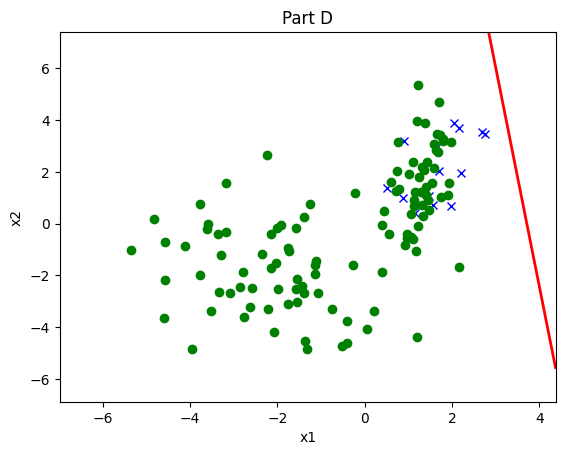

In [3]:
part_d(ds3_train, ds3_valid, ds3_test, save_path)

[[0.24130327 0.1240087  0.09731881 0.12808992 0.13074925 0.21365991
  0.17804415 0.2910147  0.19588649 0.16059545 0.2273719  0.07290069]]
Labeling rate alpha  0.17174527144749677
With Correction of 0.17174527144749677


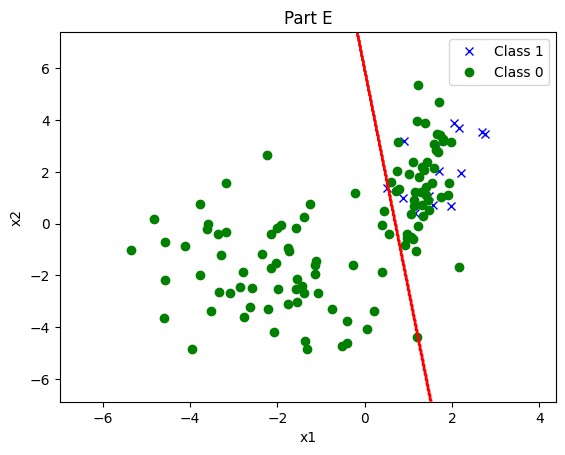

In [4]:
part_e(ds3_train, ds3_valid, ds3_test, save_path)
# scale works! 